### **This notebook presents a formulation and solution of the following operations research question**.

I'm using the PYOMO framework and the GLPK solver.

<a href="https://colab.research.google.com/github/anapdinizm/operations-research-problems/blob/main/notebooks/Question_1_Schedule_Problem.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://raw.githubusercontent.com/anapdinizm/operations-research-problems/main/notebooks/Question_1_Schedule_Problem.ipynb"><img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>

In [ ]:
# Installing necessary packages
!apt-get install libglpk-dev
!apt-get install -y -qq glpk-utils
!pip install glpk
!pip install pyomo


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libglpk-dev is already the newest version (5.0-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


## **Question 1**

### **STATEMENT**



One of the most common challenges in an industry is the scheduling problem.

You have been hired to assist in the decision-making process for a company that manufactures pipes. A set of jobs needs to be sequenced on a single machine. The **objective is** to minimize the Makespan, in other words, you have **to minimize the total duration of time needed to complete the set of jobs**.

**Each job has its processing time on the machine and must be delivered by a deadline**.

Additionally, due to raw material constraints or delays from the previous production line, **each job has a release date for production. Preemptions are not allowed**, i.e., once the job is allocated to the machine, the job holds the machine busy until the task is completed. The setup times between jobs are an important factor to be considered. It represents the clean-up time between two distinct jobs.

*   You should create an instance of at least 10 jobs and use it in solving the problem. This file should also be sent.
*   What will be the optimized sequence for the instance created?
*   What is the value of the makespan for the optimal solution?
*   Besides the problem solution, please also send the mathematical formulation and your code (commented).

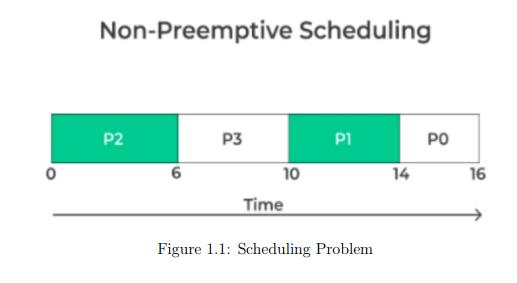


### **SOLUTION**

In [ ]:
#Importing necessary libraries
import pandas as pd
from pyomo.environ import *
import matplotlib.pyplot as plt
from IPython.display import display
from matplotlib.lines import Line2D

#### **Data**
* The instance of 11 jobs contains the release time, the duration of the job, the cleanup time and the expected deadline for completion time of the job.
* The structure is a hash table, which provides efficiency for finding the values of each job.
* I considered that the cleanup time of a job $j$ is equal to each rank $k$, then it is possible to reduce an N$\times$N matrix to a vector.
* The data is represented below by "JOBS".

In [ ]:
JOBS = {
    '1': {'release': 0, 'duration': 4, 'cleanup':3, 'deadline': 10},
    '2': {'release': 9, 'duration': 2, 'cleanup':2, 'deadline': 22},
    '3': {'release': 10, 'duration': 5, 'cleanup':2, 'deadline': 20},
    '4': {'release': 35, 'duration': 6, 'cleanup':4, 'deadline': 45},
    '5': {'release': 40, 'duration': 4, 'cleanup':2, 'deadline': 50},
    '6': {'release': 20, 'duration': 2, 'cleanup':2, 'deadline':  27},
    '7': {'release': 24, 'duration': 3, 'cleanup':1, 'deadline': 30},
    '8': {'release': 15, 'duration': 3, 'cleanup':1, 'deadline': 20},
    '9': {'release': 23, 'duration': 7, 'cleanup':1, 'deadline': 35},
    '10': {'release': 36, 'duration': 2, 'cleanup':1, 'deadline': 39},
    '11': {'release': 30, 'duration': 3, 'cleanup':4, 'deadline': 40},
}
display(pd.DataFrame(JOBS).T)

,release,duration,cleanup,deadline
1,0,4,3,10
2,9,2,2,22
3,10,5,2,20
4,35,6,4,45
5,40,4,2,50
6,20,2,2,27
7,24,3,1,30
8,15,3,1,20
9,23,7,1,35
10,36,2,1,39


#### **Variables**

I'm going to use the binary variable $rank_{jk}$ ( $\forall$ j, $\forall$ k $\in$ JOBS = {1 ... N}) that have the value 1 if job j has the position (rank) k and 0 in all other cases. There can be only one job per position k and every job j takes a single position.

Variables considered:
> $\text{rank}_{jk}$ binary variable representing the schedule job $j$ in rank $k$

> $\text{start}_{j}$  is the time at which job $j$ starts

> $\text{ispastdeadline}_{j}$  binary variable representing the job $j$ completed with delay
    
> $\text{maxpastdeadline}$ is the maximum time of the delayed job $j$

> $\text{pastdeadline}_{j}$ is the time by which the completion of job $j$ is delayed.

> $\text{early}_{j}$ is the time at which job $j$ was finished before the deadline.

> $\text{makespan}$ is the time to complete *all* jobs



#### **Constraints**
Preemptions are not allowed, then job j must finish before k starts, and the job cannot start until it is released for processing.
\begin{align*}
\text{start}_{j} & \geq \text{release}_{j}\\
\end{align*}

Once released for processing, processing continues until the job is completed. The completion time is compared to the deadline and the result is stored in either the early or pastdeadline decision variable. These decision variables are needed to handle cases where it may not be possible to complete all jobs by the due time.

\begin{align*}
\text{ start}_j + \text{ duration}_j + \text{ cleanup}_j + \text{ early}_j = \text{ deadline}_j + \text{ pastdeadline}_j \text{, }\forall j \in J\\
\end{align*}

The maximum delayed job is represented by $\text{maxpastdeadline}$, and this is greater than or equal to any delayed job time $\text{ pastdeadline}_j$. The $\text{makespan}$ is greater than or equal to any job realese to deadline period.

\begin{align*}
\text{ pastdeadline}_j \le \text{ maxpastdeadline} \text{, }\forall j \in J\\
\text{ start}_j + \text{ duration}_j + \text{ cleanup}_j \le \text{ makespan} \text{, }\forall j \in J\\
\end{align*}

The final set of constraints requires that no pair of jobs run on the same machine at the same time. To do this, each unique pair $(j,k)$ is considered, with the constraint $j < k$ to imposed to avoid considering the same pair twice. Then for any unique pair $j$ and $k$, either $j$ finishes before $k$ starts, or $k$ finishes before $j$ starts. This is expressed as follows:

\begin{align*}
 \text{ pastdeadline}_j \le \text{ M}\text{ ispastdeadline}_j \text{, }\forall j \in J\\
\text{ start}_j + \text{ duration}_j + \text{ cleanup}_j \le \text{ start}_k + \text{ M }(1-\text{ rank}_{jk}) \text{, }\forall j < k \in J\\
\text{ start}_k + \text{ duration}_k + \text{ cleanup}_k \le \text{ start}_j + \text{ M }\text{ rank}_{jk} \text{, }\forall j < k \in J
\end{align*}

For these constraints, the BigM method was used. One of the many uses of Big M is to ensure the equality of variables only when a particular binary variable takes one value, but to leave the variables "open" when the binary variable takes its opposite value.

#### **Objective function**

The objective function is to minimize the total time required to complete the set of jobs (makespan).
\begin{align}
\text{Min } & \text{ makespan} \\
\end{align}

#### **Math model**

\begin{align}
\text{Min } & \text{ makespan} \\
\text{s.t. } & \text{ start}_j \ge \text{ release}_j \text{, }\forall j \in J \\
\text{     } & \text{ start}_j + \text{ duration}_j + \text{ cleanup}_j + \text{ early}_j = \text{ deadline}_j + \text{ pastdeadline}_j \text{, }\forall j \in J\\
\text{     } & \text{ pastdeadline}_j \le \text{ maxpastdeadline} \text{, }\forall j \in J\\
\text{     } & \text{ start}_j + \text{ duration}_j + \text{ cleanup}_j \le \text{ makespan} \text{, }\forall j \in J\\
\text{     } & \text{ pastdeadline}_j \le \text{ M}\text{ ispastdeadline}_j \text{, }\forall j \in J\\
\text{     } &  \text{ start}_j + \text{ duration}_j + \text{ cleanup}_j \le \text{ start}_k + \text{ M }(1-\text{ rank}_{jk}) \text{, }\forall j < k \in J\\
\text{     } &  \text{ start}_k + \text{ duration}_k + \text{ cleanup}_k \le \text{ start}_j + \text{ M }\text{ rank}_{jk} \text{, }\forall j < k \in J \\
\text{     } & \text{ start}_j, \text{ early}_j, \text{ pastdeadline}_j, \text{ maxpastdeadline}, \text{ makespan} \ge 0 \text{, }\forall j \in J\\
\text{     } & \text{ rank}_{jk}, \text{ ispastdeadline}_j \in \{0,1\} \text{, }\forall j, \forall k \in J
\end{align}

#### **Code**

In [ ]:
def schedule_problem(JOBS):
    '''
    This function creates the model and solves the scheduling problem for one machine.
    The input is a dictionary with the characteristics of the jobs: release,
    duration, cleanup, deadline.
    It uses BigM to help to solve the problem with the binary variables on constraints.
    The output is the model (m) and the result object of the solution (status).
    '''
    # create the model
    m = ConcreteModel()

    # index set
    J = list(JOBS.keys())
    m.J = Set(initialize=J, ordered=True)

    # variables
    m.start      = Var(J, domain=NonNegativeReals)
    m.makespan   = Var(domain=NonNegativeReals)
    m.pastdeadline    = Var(J, domain=NonNegativeReals)
    m.early      = Var(J, domain=NonNegativeReals)
    m.ispastdeadline  = Var(J, domain=Binary)
    m.maxpastdeadline = Var(domain=NonNegativeReals)
    m.rank = Var(J, J, domain=Binary)

    # The BigM was used in constraints due to binary variables to help find a solution.
    BigM = 1000

    #Setting the objective function, minimize the makespan
    m.OBJ = Objective(
        expr = m.makespan,
        sense = minimize
    )

    #Setting all the constraints
    m.cons = ConstraintList()
    for j in J:
        m.cons.add(m.start[j] >= JOBS[j]['release'])
        m.cons.add(m.start[j] + JOBS[j]['duration'] + JOBS[j]['cleanup'] + m.early[j] == JOBS[j]['deadline'] + m.pastdeadline[j])
        m.cons.add(m.pastdeadline[j] <= m.maxpastdeadline)
        m.cons.add(m.start[j] + JOBS[j]['duration'] + JOBS[j]['cleanup'] <= m.makespan)
        m.cons.add(m.pastdeadline[j] <= BigM*m.ispastdeadline[j])
        for k in J:
            if j < k:
                m.cons.add(m.start[j] + JOBS[j]['duration'] + JOBS[j]['cleanup'] <= m.start[k] + BigM*(1-m.rank[j,k]))
                m.cons.add(m.start[k] + JOBS[k]['duration'] + JOBS[k]['cleanup'] <= m.start[j] + BigM*(m.rank[j,k]))

    #Call the solver glpk
    status = SolverFactory('glpk',executable='/usr/bin/glpsol').solve(m)

    return status, m

In [ ]:
#Call the function schedule_problem to solve the problem
# It takes about 50 seconds to run
status, m = schedule_problem(JOBS)

#### **Results**

In [ ]:
# Print the status of the solved problem
print("Status = %s" % status.solver.termination_condition)

Status = optimal


In [ ]:
# Print the result of optimization, minimum value of makespan
print("Minimum value of makespan = %.2f" % value(m.OBJ))

Minimum value of makespan = 66.00


In [ ]:
for j in JOBS.keys():
  JOBS[j]['start'] = m.start[j]()
  JOBS[j]['finish'] = m.start[j]() + JOBS[j]['duration']
  JOBS[j]['pastdeadline'] = m.pastdeadline[j]()
  JOBS[j]['early'] = m.early[j]()
  JOBS[j]['ispastdeadline'] = m.ispastdeadline[j]()

# display table of results
results = pd.DataFrame(JOBS)
results['Total'] = results.sum(axis=1)
results.loc[['deadline','finish','release','start'],'Total'] = ''
display(results)

,1,2,3,4,5,6,7,8,9,10,11,Total
release,0.0,9.0,10.0,35.0,40.0,20.0,24.0,15.0,23.0,36.0,30.0,
duration,4.0,2.0,5.0,6.0,4.0,2.0,3.0,3.0,7.0,2.0,3.0,41.0
cleanup,3.0,2.0,2.0,4.0,2.0,2.0,1.0,1.0,1.0,1.0,4.0,23.0
deadline,10.0,22.0,20.0,45.0,50.0,27.0,30.0,20.0,35.0,39.0,40.0,
start,2.0,9.0,13.0,50.0,60.0,39.0,32.0,20.0,24.0,36.0,43.0,
finish,6.0,11.0,18.0,56.0,64.0,41.0,35.0,23.0,31.0,38.0,46.0,
pastdeadline,0.0,0.0,0.0,15.0,16.0,16.0,6.0,4.0,0.0,0.0,10.0,67.0
early,1.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,13.0
ispastdeadline,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,6.0


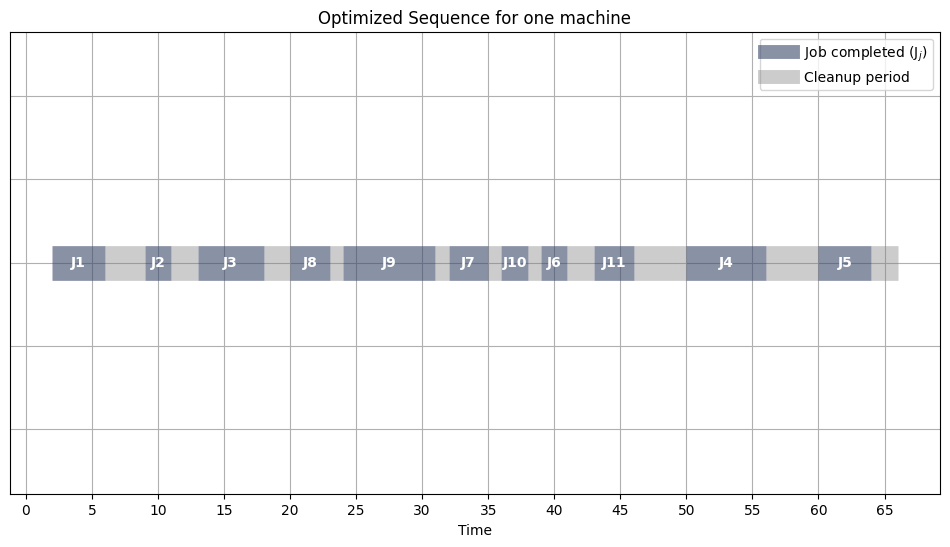

In [ ]:
%matplotlib inline

def optimized_sequence(JOBS):
    '''
    This function prints the optimized sequence result from the scheduling problem.
    '''
    plt.figure(figsize=(12,6))
    for j in sorted(JOBS.keys()):
        plt.plot([JOBS[j]['start'],JOBS[j]['finish']],[1,1],
             color='#3a486a',alpha=0.6,lw=25,solid_capstyle="butt")
        plt.plot([JOBS[j]['finish'],JOBS[j]['finish']+JOBS[j]['cleanup']],[1,1],
             color='gray',alpha=0.4,lw=25,solid_capstyle="butt")
        plt.text((JOBS[j]['start'] + JOBS[j]['finish'])/2.0,1,
            'J' + j, color='white', weight='bold',
            horizontalalignment='center', verticalalignment='center')

    jobs_legend = [
        Line2D([0], [0], c="#3a486a", lw=10, alpha=0.6),
        Line2D([0], [0], c="gray", lw=10, alpha=0.4),
    ]
    plt.legend(
        jobs_legend,
        ["Job completed (J$_j$)", "Cleanup period"],
    )
    plt.ylim(plt.ylim()[0]-0.5,plt.ylim()[1]+0.5)

    plt.xticks(ticks=range(0,70,5))
    plt.tick_params(left = False, labelleft = False)
    plt.title('Optimized Sequence for one machine')
    plt.xlabel('Time')
    plt.grid()

optimized_sequence(JOBS)

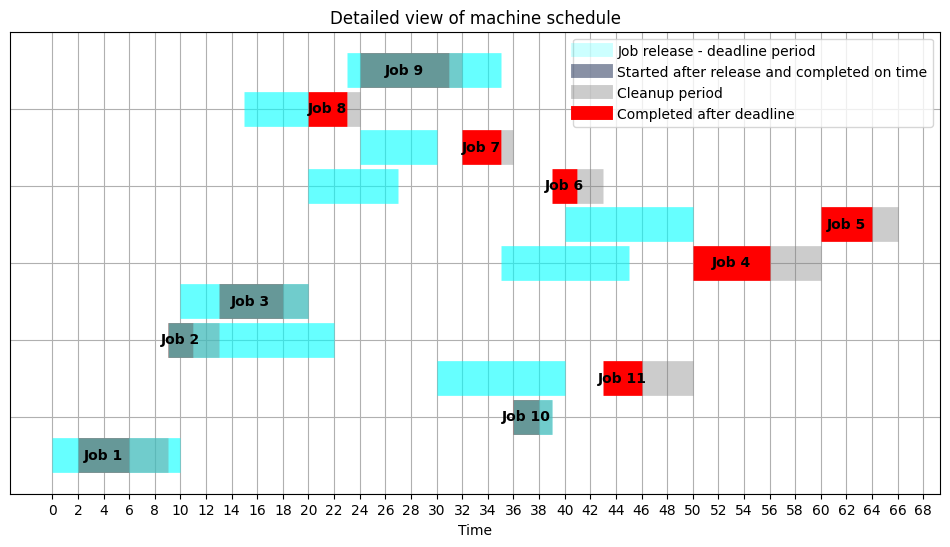

In [ ]:
%matplotlib inline

def detailed_view(JOBS):
    '''
    This function prints in detail the optimized sequence result from the scheduling problem.
    The figure shows the job release up to the deadline period,
    the jobs that started after release and finished on time,
    the clean-up periods and the jobs completed after the deadline.
    '''
    plt.figure(figsize=(12,6))
    idx = 0
    for j in sorted(JOBS.keys()):
        idx += 1
        plt.plot([JOBS[j]['start'],JOBS[j]['finish']],[idx,idx],
             color='red',alpha=1.0,lw=25,solid_capstyle="butt")
        plt.plot([JOBS[j]['release'],JOBS[j]['deadline']],[idx,idx],
             color='cyan',alpha=0.6,lw=25,solid_capstyle="butt")
        plt.plot([JOBS[j]['finish'],JOBS[j]['finish']+JOBS[j]['cleanup']],[idx,idx],
             color='gray',alpha=0.4,lw=25,solid_capstyle="butt")
        plt.text((JOBS[j]['start'] + JOBS[j]['finish'])/2.0,idx,
            'Job ' + j, color='black', weight='bold',
            horizontalalignment='center', verticalalignment='center')

    jobs_legend = [
        Line2D([0], [0], c="cyan", lw=10, alpha=0.2),
        Line2D([0], [0], c="#3a486a", lw=10, alpha=0.6),
        Line2D([0], [0], c="gray", lw=10, alpha=0.4),
        Line2D([0], [0], c="red", lw=10, alpha=1),
    ]
    plt.legend(
        jobs_legend,
        ["Job release - deadline period", "Started after release and completed on time", "Cleanup period", "Completed after deadline"],
    )
    plt.ylim(plt.ylim()[0]-0.5,plt.ylim()[1]+0.5)

    plt.xticks(ticks=range(0,70,2))
    plt.tick_params(left = False, labelleft = False)
    plt.title('Detailed view of machine schedule')
    plt.xlabel('Time')
    plt.grid()

detailed_view(JOBS)

### REFERENCE

* The code was based on this github repository with the solution for Machine Bottleneck problem https://github.com/jckantor/CBE30338/blob/master/notebooks/09.03-Machine-Bottleneck.ipynb

* Hands-On Optimization with AMPL in Python. Machine Scheduling notebook https://ampl.com/mo-book/notebooks/03/machine-scheduling.html

* Christelle Gueret, Christian Prins, Marc Sevaux, "Applications of Optimization with Xpress-MP," Chapter 7, Dash Optimization Ltd, 2000.

*  Eugene L. Lawler, Jan Karel Lenstra, Alexander H. G. Rinnooy Kan, David B. Shmoys (1993-01-01). "Chapter 9 Sequencing and scheduling: Algorithms and complexity". Handbooks in Operations Research and Management Science. 4: 445–522. doi:10.1016/S0927-0507(05)80189-6. ISBN 9780444874726. ISSN 0927-0507

* Graham, R. L.; Lawler, E. L.; Lenstra, J.K.; Rinnooy Kan, A.H.G. (1979). "Optimization and Approximation in Deterministic Sequencing and Scheduling: a Survey" (PDF). Proceedings of the Advanced Research Institute on Discrete Optimization and Systems Applications of the Systems Science Panel of NATO and of the Discrete Optimization Symposium. Elsevier. pp. (5) 287–326.

* Pyomo online documentation http://pyomo.readthedocs.io/

* GLPK online documentation https://www.gnu.org/software/glpk/#TOCdocumentation
